# Chain Of Density Summarization

## Introduction

**What is Chain Of Density summarization?**

Summarizing extensive texts with AI can be challenging. Initially, an AI produces a summary, then refines it through multiple iterations, adding missing article entities. Each iteration adds new article entities to the summary, keeping length consistent, leading to an entity-dense, informative summary called Chain Of Density.

It was first introduced in the paper - From Sparse to Dense : GPT-4 Summarization with Chain of Density prompting. 

This was done in the original paper by asking GPT-4 to generate all of the rewritten summaries in a single go with the following prompt below. 

> Article: {{ARTICLE}}
>
> You will generate increasingly concise, entity-dense summaries of the
> above Article.
>
> Repeat the following 2 steps 5 times.
>
> Step 1. Identify 1-3 informative Entities (";" delimited) from the
> Article which are missing from the previously generated summary.
> Step 2. Write a new, denser summary of identical length which covers
> every entity and detail from the previous summary plus the Missing
> Entities.
>
> A Missing Entity is:
> - Relevant: to the main story.
> - Specific: descriptive yet concise (5 words or fewer).
> - Novel; not in the previous summary.
> - Faithful: present in the Article.
> - Anywhere: located anywhere in the Article.
>
> Guidelines:
> - The first summary should be long (4-5 sentences, -80 words) yet
> highly non-specific, containing little information beyond the
> entities marked as missing. Use overly verbose language and fillers
> (e.g., "this article discusses") to reach -80 words.
> - Make every word count: re-write the previous summary to improve
> flow and make space for additional entities.
> - Make space with fusion, compression, and removal of uninformative
> phrases like "the article discusses"
> - The summaries should become highly dense and concise yet
> self-contained, e.g., easily understood without the Article.
> - Missing entities can appear anywhere in the new summary.
> - Never drop entities from the previous summary. If space cannot be
> made, add fewer new entities.
>
> Remember, use the exact same number of words for each summary.
>
> Answer in JSON. The JSON should be a list (length 5) of dictionaries
> whose keys are "Missing_Entities" and "Denser_Summary"

While the original paper used a single prompt to generate the iterative generations, we can go one step better with `Instructor` and break down the process into smaller API calls - with validation along the way.

The process can be broken down as seen below.

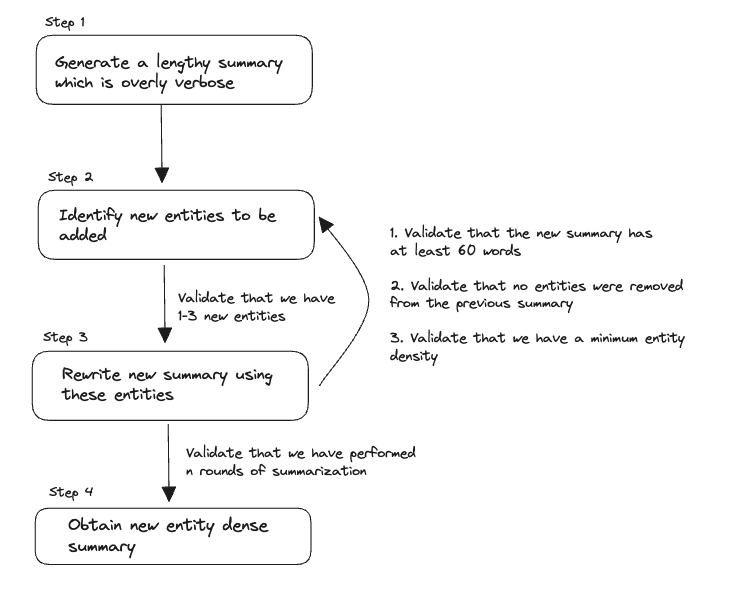

### Setup and Dependencies

We'll be using two new libraries for our demonstration 

1. `spaCy` : This provides a handful of useful utilities to do generic NLP tasks with
2. `nltk` : This was used by the original paper to count the number of tokens in our generated summaries

We'll need to install the tokenizer packages and the spacy english library before we can proceed with the rest of the lesson

In [1]:
import nltk
nltk.download('punkt')

!python -m spacy download en_core_web_sm --quiet

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Once that's done, let's now move on to writing some code.

## Definitions

There are a few different definitions which we'll need to understand in the tutorial. They are

1. Tokens and tokenizers
2. Entities
3. Entity-Dense

Once we've gotten a hang of these concepts, we'll walk through a simple implementation of a Chain Of Density summarizer

### Tokens and Tokenizers

In the original paper, the authors used `NLTK` to split the generated summary into tokens. These represent the smallest units that each sentence could be broken into where each hold semantic meaning.

Let's walk through a simple example to see how the `NLTK` tokenizer might work

In [2]:
import nltk
sentence = "My favourite type of Sashimi is Toro"

nltk.word_tokenize(sentence)

['My', 'favourite', 'type', 'of', 'Sashimi', 'is', 'Toro']

NLTK's word tokenizer does more than just split by empty whitespace. It handles a lot of nice edge cases and contractions such as `don't` or `I'm`.

In [3]:
sentence = "I'm fascinated by machine learning!"

nltk.word_tokenize(sentence)

['I', "'m", 'fascinated', 'by', 'machine', 'learning', '!']

We can then calculate the number of tokens by simply finding the `len` of the generated sequence.

In [4]:
sentence = "I'm fascinated by machine learning!"
tokens = nltk.word_tokenize(sentence)
print(tokens)
print(len(tokens))

['I', "'m", 'fascinated', 'by', 'machine', 'learning', '!']
7


### Entities

A named entity is an object in the real-world that we identify using a name. Common examples include people, countries, products or even books that we know and love. We can use the `spaCy` library for us to be able to detect the number of entities in a given sentence.

In [5]:
# First we load in the library
import spacy

# Then we initialise an NLP object. 
nlp = spacy.load("en_core_web_sm")

In [6]:
sentence = "Apple is looking at buying U.K. startup for $1 billion"

doc = nlp(sentence)
doc.ents

(Apple, U.K., $1 billion)

We can see that Spacy was able to identify unique and named entities that were present within the sentence using the `doc.ents` property. Let's see a few more examples.

In [7]:
sentence = "A knowledge graph, also known as a semantic network\
, represents real-world entities and their relationships"

doc = nlp(sentence)
doc.ents

()

In [8]:
sentence = "For example, a node representing an author like 'J.K. Rowling'\
can be connected to another node representing one of her books, 'Harry Potter'\
, with the edge 'author of'"

doc = nlp(sentence)
doc.ents

(J.K., one, Harry Potter')

As we can see from the examples above, entities are not nouns. They're direct or indirect references to people, places, concepts.

### Entity Density

Now that we know what tokens and tokens are, we can move on to our last concept - that of entity density. Entity density is simply the mean number of entities present per token within your string of text.

In [9]:
import math
nlp = spacy.load("en_core_web_sm")

def calculate_entity_density(sentence:str):
    tokens = nltk.word_tokenize(sentence)
    entities = nlp(sentence).ents
    entity_density = round(len(entities)/len(tokens),3)

    return len(tokens),len(entities),entity_density

In [10]:
sentence_1 = "A knowledge graph, also known as a semantic network\
, represents real-world entities and their relationships"

calculate_entity_density(sentence_1)

(17, 0, 0.0)

In [11]:
sentence_2 = "Apple is looking at buying U.K. startup for $1 billion"

calculate_entity_density(sentence_2)

(11, 3, 0.273)

This gives us a quantitative method to be able to understand and compare two different sentences/summaries.

We want summaries that are more entity-dense

In [12]:
summary_1 = """
This article discusses an incident that occurred during the Chinese Grand Prix
involving two racing drivers, Jenson Button and Pastor Maldonado. The two were 
competing for the 13th place when Button collided with Maldonado's vehicle, 
causing damage to both cars. The incident resulted in a penalty for Button, 
who was demoted to 14th place. Maldonado, on the other hand, had to retire from 
the race due to the damage his car sustained.
"""

summary_2 = """
Jenson Button's McLaren collided with Pastor Maldonado's Lotus during the Chinese 
Grand Prix, causing front wing damage to Button's car and rear-end damage to 
Maldonado's, forcing his retirement. Button received a five-second penalty and 
two superlicence points, dropping himto 14th. Fernando Alonso advanced two places, 
while Button was lapped by Nico Rosberg and Alonso by Sebastian Vettel and 
Kimi Raikkonen.
"""

calculate_entity_density(summary_1),calculate_entity_density(summary_2)

((82, 11, 0.134), (71, 17, 0.239))

We can see that the final summary is almost twice as dense as the first summary and is hence more *entity dense*.

## Implementation
### Data Classes

Let's start by walking through some of the data models that we'll be using as the response_model for our open ai function calls. We'll need a total of two different classes

1. Initial Summary: which is the lengthy and overly verbose article
2. Rewritten Summary : which represents

In [13]:
from pydantic import BaseModel,Field,field_validator
from typing import List

In [14]:
class InitialSummary(BaseModel):
    """
    This is an initial summary which should be long ( 4-5 sentences, ~80 words)
    yet highly non-specific, containing little information beyond the entities marked as missing.
    Use overly verbose languages and fillers (Eg. This article discusses) to reach ~80 words.
    """

    summary: str = Field(
        ...,
        description="This is a summary of the article provided which is overly verbose and uses fillers. \
        It should be roughly 80 words in length",
    )

Pydantic is extremely handy because it allows us to do two things

1. We can validate that our generated outputs are consistent with what we want, **and write vanilla python to validate so**
2. We can export the generated class definition into a simple schema that fits in perfectly with OpenAI's function calling

In [15]:
InitialSummary.model_json_schema()

{'description': 'This is an initial summary which should be long ( 4-5 sentences, ~80 words)\nyet highly non-specific, containing little information beyond the entities marked as missing.\nUse overly verbose languages and fillers (Eg. This article discusses) to reach ~80 words.',
 'properties': {'summary': {'description': 'This is a summary of the article provided which is overly verbose and uses fillers.         It should be roughly 80 words in length',
   'title': 'Summary',
   'type': 'string'}},
 'required': ['summary'],
 'title': 'InitialSummary',
 'type': 'object'}

It's important here to provide a good description of the overall class and the respective fields. This is because all of the descriptions that we write for the individual fields and the class itself **are directly used by the llm when generating outputs**.

Now, as a quick recap, when we rewrite our summaries at each step, we're performing a few things

1. We identify any entities from the original article that are relevant which are **missing from our current summary**
2. We then rewrite our summary, making sure to include as many of these new entities as possible with the goal of increasing the entity density of the new summary
3. We then make sure that we have included all of the entities in our previous summary in the new rewritten summary.

We can express this in the form of the data model seen below called `RewrittenSummary`.

In [16]:
class RewrittenSummary(BaseModel):
    """
    This is a new, denser summary of identical length which covers every entity
    and detail from the previous summary plus the Missing Entities.

    Guidelines
    - Make every word count : Rewrite the previous summary to improve flow and make space for additional entities
    - Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
    - The new summary should be highly dense and concise yet self-contained, eg., easily understood without the Article.
    - Make space with fusion, compression, and removal of uninformative phrases like "the article discusses"
    - Missing entities can appear anywhere in the new summary

    An Entity is a real-world object that's assigned a name - for example, a person, country a product or a book title.
    """

    summary: str = Field(
        ...,
        description="This is a new, denser summary of identical length which covers every entity and detail from the previous summary plus the Missing Entities. It should have the same length ( ~ 80 words ) as the previous summary and should be easily understood without the Article",
    )
    absent: List[str] = Field(
        ...,
        default_factory=list,
        description="this is a list of Entities found absent from the new summary that were present in the previous summary",
    )
    missing: List[str] = Field(
        default_factory=list,
        description="This is a list of 1-3 informative Entities from the Article that are missing from the new summary which should be included in the next generated summary.",
    )

We'd also want our rewritten summary to have

1. No missing entities => `absent` should have a length of 0
2. New entities to be added in the next rewrite -> `missing` should have at least 1 entry
3. A minimum length of 60 tokens and to have a density of at least 0.08 ( **NOTE**: 60 tokens and the 0.08 cut off are chosen arbitrarily, feel free to adjust them even higher if you wish. However, this might require you to add more retries in your code )

We can do so using the `field_validator` that we learnt in the previous lesson. This allows us to add in a validator for a specific field to ensure it meets our requirements. 

This gives us the final definition of our `RewrittenSummary` class as seen below

This gives us the final definition of our `RewrittenSummary` class as seen below

In [17]:
class RewrittenSummary(BaseModel):
    """
    This is a new, denser summary of identical length which covers every entity
    and detail from the previous summary plus the Missing Entities.

    Guidelines
    - Make every word count : Rewrite the previous summary to improve flow and make space for additional entities
    - Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
    - The new summary should be highly dense and concise yet self-contained, eg., easily understood without the Article.
    - Make space with fusion, compression, and removal of uninformative phrases like "the article discusses"
    - Missing entities can appear anywhere in the new summary

    An Entity is a real-world object that's assigned a name - for example, a person, country a product or a book title.
    """

    summary: str = Field(
        ...,
        description="This is a new, denser summary of identical length which covers every entity and detail from the previous summary plus the Missing Entities. It should have the same length ( ~ 80 words ) as the previous summary and should be easily understood without the Article",
    )
    absent: List[str] = Field(
        ...,
        default_factory=list,
        description="this is a list of Entities found absent from the new summary that were present in the previous summary",
    )
    missing: List[str] = Field(
        default_factory=list,
        description="This is a list of 1-3 informative Entities from the Article that are missing from the new summary which should be included in the next generated summary.",
    )
        
    
    @field_validator("summary")
    def min_length(cls, v: str):
        tokens = nltk.word_tokenize(v) 
        num_tokens = len(tokens)
        if num_tokens < 60:
            raise ValueError(
                "The current summary is too short. Please make sure that you generate a new summary that is around 80 words long."
            )
        return v
    
    @field_validator("missing")
    def has_missing_entities(cls, missing_entities: List[str]):
        if len(missing_entities) == 0:
            raise ValueError(
                "You must identify 1-3 informative Entities from the Article which are missing from the previously generated summary to be used in a new summary"
            )
        return missing_entities
    
    @field_validator("absent")
    def has_no_absent_entities(cls, absent_entities: List[str]):
        absent_entity_string = ",".join(absent_entities)
        if len(absent_entities) > 0:
            print(f"Detected absent entities of {absent_entity_string}")
            raise ValueError(
                f"Do not omit the following Entities {absent_entity_string} from the new summary"
            )
        return absent_entities
    
    @field_validator("summary")
    def min_entity_density(cls, v: str):
        tokens = nltk.word_tokenize(v)
        num_tokens = len(tokens)
    
        # Extract Entities
        doc = nlp(v) 
        num_entities = len(doc.ents)
    
        density = num_entities / num_tokens
        if density < 0.08: 
            raise ValueError(
                f"The summary of {v} has too few entities. Please regenerate a new summary with more new entities added to it. Remember that new entities can be added at any point of the summary."
            )
    
        return v

### Putting it all together

Now that we have our models, let's implement a function to summarize a piece of text using a Chain Of Density summarization

In [18]:
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI()) 

def summarize_article(article: str, summary_steps: int = 3):
    summary_chain = []
    # We first generate an initial summary
    summary: InitialSummary = client.chat.completions.create(  
        model="gpt-4-1106-preview",
        response_model=InitialSummary,
        messages=[
            {
                "role": "system",
                "content": "Write a summary about the article that is long (4-5 sentences) yet highly non-specific. Use overly, verbose language and fillers(eg.,'this article discusses') to reach ~80 words",
            },
            {"role": "user", "content": f"Here is the Article: {article}"},
            {
                "role": "user",
                "content": "The generated summary should be about 80 words.",
            },
        ],
        max_retries=2,
    )
    prev_summary = None
    summary_chain.append(summary.summary)
    for i in range(summary_steps):
        missing_entity_message = (
            []
            if prev_summary is None
            else [
                {
                    "role": "user",
                    "content": f"Please include these Missing Entities: {','.join(prev_summary.missing)}",
                },
            ]
        )
        new_summary: RewrittenSummary = client.chat.completions.create( 
            model="gpt-4-1106-preview",
            messages=[
                {
                    "role": "system",
                    "content": """
                You are going to generate an increasingly concise,entity-dense summary of the following article.

                Perform the following two tasks
                - Identify 1-3 informative entities from the following article which is missing from the previous summary
                - Write a new denser summary of identical length which covers every entity and detail from the previous summary plus the Missing Entities

                Guidelines
                - Make every word count: re-write the previous summary to improve flow and make space for additional entities
                - Make space with fusion, compression, and removal of uninformative phrases like "the article discusses".
                - The summaries should become highly dense and concise yet self-contained, e.g., easily understood without the Article.
                - Missing entities can appear anywhere in the new summary
                - Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
                """,
                },
                {"role": "user", "content": f"Here is the Article: {article}"},
                {
                    "role": "user",
                    "content": f"Here is the previous summary: {summary_chain[-1]}",
                },
                *missing_entity_message,
            ],
            max_retries=3, 
            max_tokens=1000,
            response_model=RewrittenSummary,
        )
        summary_chain.append(new_summary.summary)
        prev_summary = new_summary

    return summary_chain

### Trial Run

Let's try running this on some sample text which we can import in from our repository. We've provided a sample article in a file called `article.txt`

In [19]:
with open("./assets/article.txt","r+") as file:
    article = file.readline()

In [ ]:
%%time

summaries = summarize_article(article)

We can see that it took roughly 40 seconds to do an iterative chain of density using this article. But does our approach increase the density of each individual summary? We can check by calculating the entity density of each summary in our list of summaries using the `calculate_entity_density` function we defined above.

In [ ]:
for index,summary in enumerate(summaries):
    tokens,entity,density = calculate_entity_density(summary)
    print(f"Article {index+1} -> Results (Tokens: {tokens}, Entity Count: {entity}, Density: {density})")

We can take a look at the articles themselves to see if they qualitatively show improvement

In [ ]:
for summary in summaries:
    print(f"\n{summary}\n")

As we can see, the articles progressively introduce more entities and become more entity dense. We've performed 4 rounds of summarization here but you could definitely do with maybe 2-3 if latency is a significant issue.

## Future Steps

This guide showed how to to generate complex summaries using chain of density summarization. We spent some time covering how to apply more complex validators - using `spaCy` and `NLTK` to ensure we had a minimum number of tokens and entity density as well as how you might apply instructor in a multi-stage process.

By building in validation at each step of the proccess, this helps to improve the performance of your LLM across various tasks.

For those looking to delve deeper, here are some to-do lists to explore.

- **Validate Increasing Entity Density**: `Pydantic` exposes a more complex validator that can take in an arbitrary python dictionary. Use the validation context to check the entity density of the previous summary and the new summary to validate that our model has generated a more entity-dense rewrite
- **Fine-Tuning** : `Instructor` comes with a simple to use interface to help you fine-tune other OpenAI models for your needs. This can be accomplished by capturing the outputs of LLMs using the `Instructions` module to generate training data for fine-tuning.

By accomplishing these tasks, you'll gain practical experience in tuning your models to suit your specific tasks as well as build in more complex validation processes when working with LLMs to ensure more reliable, accurate and consistent outputs.